In [1]:
######################################################
############# Lending Tree Loan Status ###############
################ Catboost HPO GPU ####################
################### Upsampling ####################### 
######################################################

In [2]:
!pip install catboost
!pip install eli5
!pip install lime
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import joblib
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import STATUS_OK
from catboost import CatBoostClassifier
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin, tpe, Trials
import csv
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 as eli
from eli5.sklearn import PermutationImportance 
from eli5 import show_weights
import webbrowser
from eli5.sklearn import explain_weights_sklearn
from eli5.formatters import format_as_dataframe, format_as_dataframes
from eli5 import show_prediction
import lime
from lime import lime_tabular

     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 106 kB 5.1 MB/s 
     |████████████████████████████████| 275 kB 5.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=3ebefc865c809a0d2f00980334d20d2d4b17bc2dd947d09172b713b117b141b9
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [5]:
# Set seed 
seed_value = 42
os.environ['LoanStatus_CatboostGPU_Upsampling'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [6]:
# Read data
df = pd.read_csv('LendingTree_LoanStatus_final.csv', low_memory=False)

In [7]:
# Separate input features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [8]:
###############################################################################
########################   1. Oversample minority class #######################
###############################################################################
# Setting up testing and training sets for oversampling minor class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=seed_value)

# Concatenate training data back together
df1 = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
current = df1[df1.loan_status==0]
default = df1[df1.loan_status==1]

del df1

# Upsample minority
default_upsampled = resample(default,
                          replace=True, # sample with replacement
                          n_samples=len(current), # match number in majority 
                          random_state=seed_value) 

# Combine majority and upsampled minority
upsampled = pd.concat([current, default_upsampled])

del default_upsampled, current, default

# Examine counts of new class
print('\nExamine Loan Status after oversampling minority class') 
print(upsampled.loan_status.value_counts())
print('======================================================================')

# Separate input features and target of upsampled train data
X_train = upsampled.drop('loan_status', axis=1)
y_train = upsampled.loan_status

del upsampled


Examine Loan Status after oversampling minority class
0    1511066
1    1511066
Name: loan_status, dtype: int64


In [9]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Catboost/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/Catboost/trialOptions


In [ ]:
###############################################################################
###################### Catboost GPU HPO for Upsampling Set #####################
############################## 100 Trials ######################################
################################################################################
# Define the number of trials
NUM_EVAL = 300

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=3, shuffle=True, random_state=seed_value)

# Define a function for optimization of hyperparameters
def catboost_hpo(config):
    """Catboost HPO"""
    
    # Keep track of evaluations
    global ITERATION
    
    ITERATION += 1  
    
    # Parameters that are integers to remain integers
    config['iterations'] = int(config['iterations'])   
    
    # Start hyperopt at 3 for max_depth   
    config['depth'] = int(config['depth']) + 3
 
    # Define model type
    cat = CatBoostClassifier(
        random_state=seed_value,
        loss_function='Logloss', 
        eval_metric='AUC',
        early_stopping_rounds=1000,
        rsm=1,
        task_type='GPU', 
        logging_level='Silent',
        **config)
    
    # Start timer for each trial
    start = timer()
    
    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(cat, X_train, y_train, scoring='roc_auc', 
                              cv=kfolds)
    
    run_time = timer() - start
    # Extract the best score
    best_score = np.max(scores)
    
    # Loss must be minimized
    loss = 1 - best_score

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, config, ITERATION, run_time])
    
    return {'loss': loss, 'params': config, 'iteration': ITERATION, 
            'train_time': run_time, 'status': STATUS_OK}    

# Define parameter grid
catboost_tune_kwargs= {
    'iterations': hp.choice('iterations', np.arange(100, 500, dtype=int)),
    'depth': hp.choice('depth', np.arange(3, 10, dtype=int)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1e-2, 1e0), 
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.3),                              
    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(2, 20, dtype=int)),
    'one_hot_max_size': hp.choice('one_hot_max_size', np.arange(2, 20, dtype=int)),  
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.0),
    }
    
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'Catboost_HPO_Upsampling_300_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global  ITERATION
ITERATION = 0
bayesOpt_Upsampling_trials = Trials()

In [ ]:
# Begin HPO trials for Upsampling data
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))

best_param = fmin(catboost_hpo, catboost_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_Upsampling_trials,
                  rstate= np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-11 02:17:55.736042
100%|██████████| 300/300 [3:24:49<00:00, 40.96s/it, best loss: 1.9573690667239017]
Start Time           2022-02-11 02:17:55.736042
End Time             2022-02-11 05:42:45.140234
3:24:49


In [ ]:
# Sort the trials with lowest loss (highest AUC) 
bayesOpt_Upsampling_trials_results = sorted(bayesOpt_Upsampling_trials.results, 
                                            key = lambda x: x['loss'])
print('Upsampling HPO GPU 300 trials: Top two trials with the lowest loss (highest AUC)')
print(bayesOpt_Upsampling_trials_results[:2])

Upsampling HPO GPU 300 trials: Top two trials with the lowest loss (highest AUC)
[{'loss': 1.9573690667239017, 'params': {'depth': 6, 'iterations': 209, 'l2_leaf_reg': 0.3258948761851098, 'learning_rate': 0.00013510336684909182, 'min_data_in_leaf': 2, 'one_hot_max_size': 2, 'scale_pos_weight': 0.40174760984637287}, 'iteration': 146, 'train_time': 21.761868355000843, 'status': 'ok'}, {'loss': 1.9588298628994352, 'params': {'depth': 6, 'iterations': 116, 'l2_leaf_reg': 0.2438578789209958, 'learning_rate': 0.0003641712068393032, 'min_data_in_leaf': 9, 'one_hot_max_size': 2, 'scale_pos_weight': 0.4537388406626548}, 'iteration': 151, 'train_time': 15.271269250999467, 'status': 'ok'}]


In [10]:
# Access results
results = pd.read_csv('Catboost_HPO_Upsampling_300_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [11]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Catboost/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Catboost/Model_PKL


In [12]:
# Re-create the best model and train on the training data
best_bayes_Upsampling_model = CatBoostClassifier(loss_function='Logloss', 
                                                 eval_metric='AUC',
                                                 early_stopping_rounds=1000,
                                                 rsm=1, 
                                                 task_type='GPU', 
                                                 logging_level='Silent', 
                                                 random_state=seed_value,
                                                 **best_bayes_params)

# Fit the model
best_bayes_Upsampling_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Upsampling_300_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_bayes_Upsampling_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Upsampling_300_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Catboost HPO Upsampling 300trials GPU')
y_train_pred = best_bayes_Upsampling_model.predict(X_train)
y_test_pred = best_bayes_Upsampling_model.predict(X_test)

# Predict based on training 
y_pred_Upsampling_HPO = best_bayes_Upsampling_model.predict(X_test)

print('Results from Catboost HPO 300 GPU on Upsampling Data:')
print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test, y_pred_Upsampling_HPO)
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_Upsampling_HPO))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test, y_pred_Upsampling_HPO))
print('Precision score : %.3f'%precision_score(y_test, y_pred_Upsampling_HPO))
print('Recall score : %.3f'%recall_score(y_test, y_pred_Upsampling_HPO))
print('F1 score : %.3f'%f1_score(y_test, y_pred_Upsampling_HPO))


Model Metrics for Catboost HPO Upsampling 300trials GPU
Results from Catboost HPO 300 GPU on Upsampling Data:


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    377848
           1       0.91      0.81      0.86     54625

    accuracy                           0.97    432473
   macro avg       0.94      0.90      0.92    432473
weighted avg       0.96      0.97      0.97    432473



Confusion matrix:
[[373405   4443]
 [ 10319  44306]]


Accuracy score : 0.966
Precision score : 0.909
Recall score : 0.811
F1 score : 0.857


In [ ]:
# Evaluate predictive probability on the testing data 
preds = best_bayes_Upsampling_model.predict_proba(X_test)[:, 1]

print('The best model from Upsampling Bayes 300 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Upsampling Bayes 300 GPU trials optimization scores 0.95791 AUC ROC on the test set.
This was achieved after 146 search iterations


In [14]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Catboost/bayesParams/

/content/drive/MyDrive/LoanStatus/ML/Catboost/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_Catboost_HPO_Upsampling_300_GPU.csv', 
                    index = False)

In [ ]:
# Convert data types for graphing
bayes_params['depth'] = bayes_params['depth'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['l2_leaf_reg'] = bayes_params['l2_leaf_reg'].astype('float64')
bayes_params['min_data_in_leaf'] = bayes_params['min_data_in_leaf'].astype('float64')
bayes_params['one_hot_max_size'] = bayes_params['one_hot_max_size'].astype('float64')

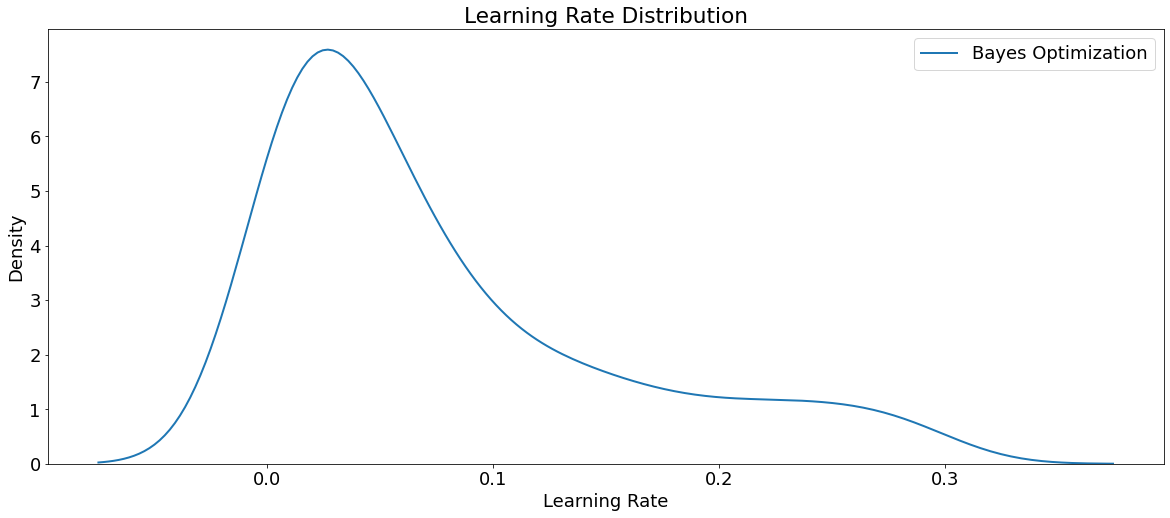

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

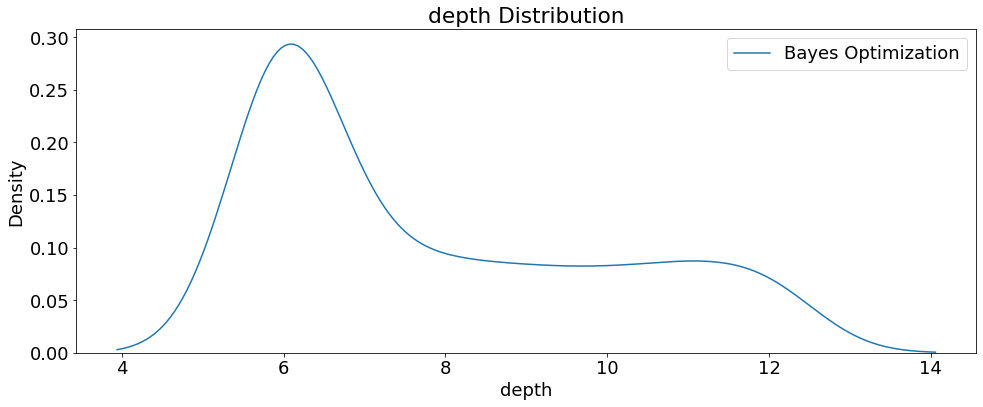

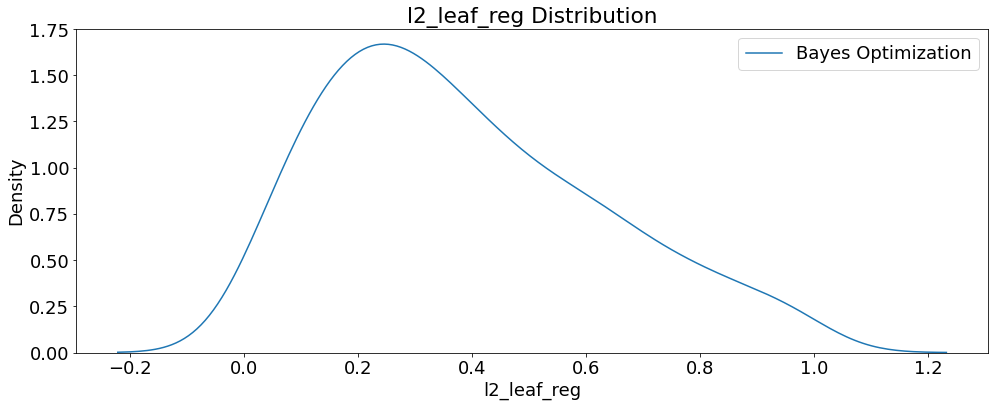

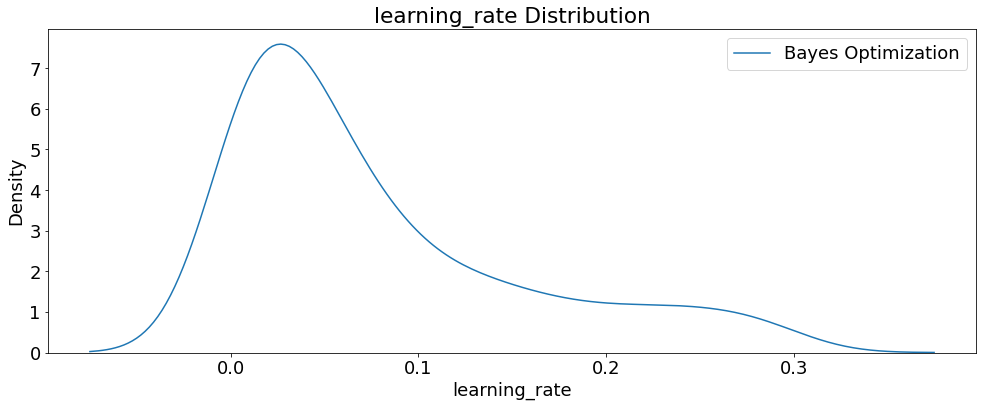

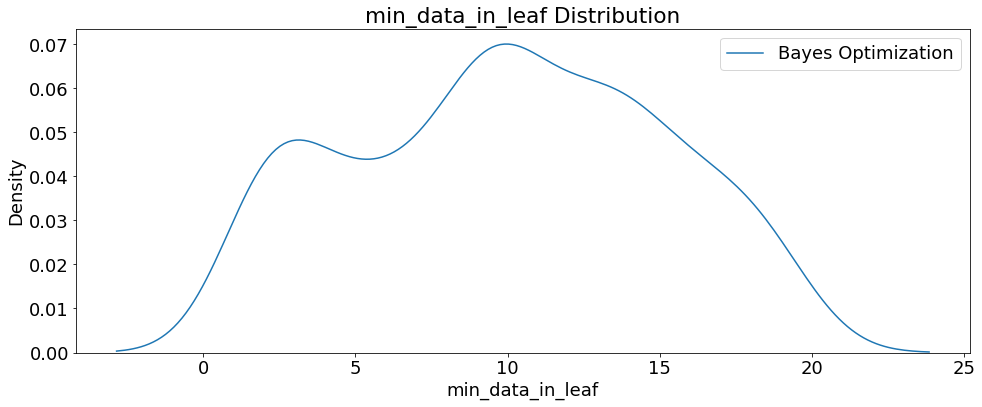

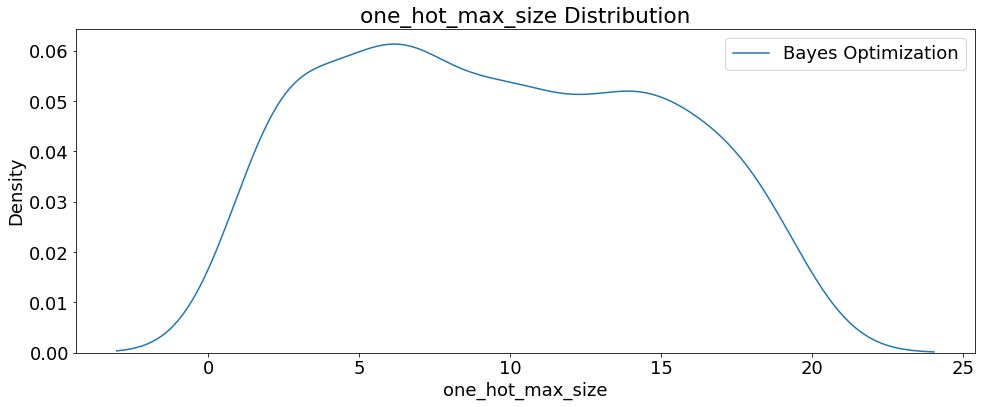

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'scale_pos_weight', 'iterations']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label = 'Bayes Optimization')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


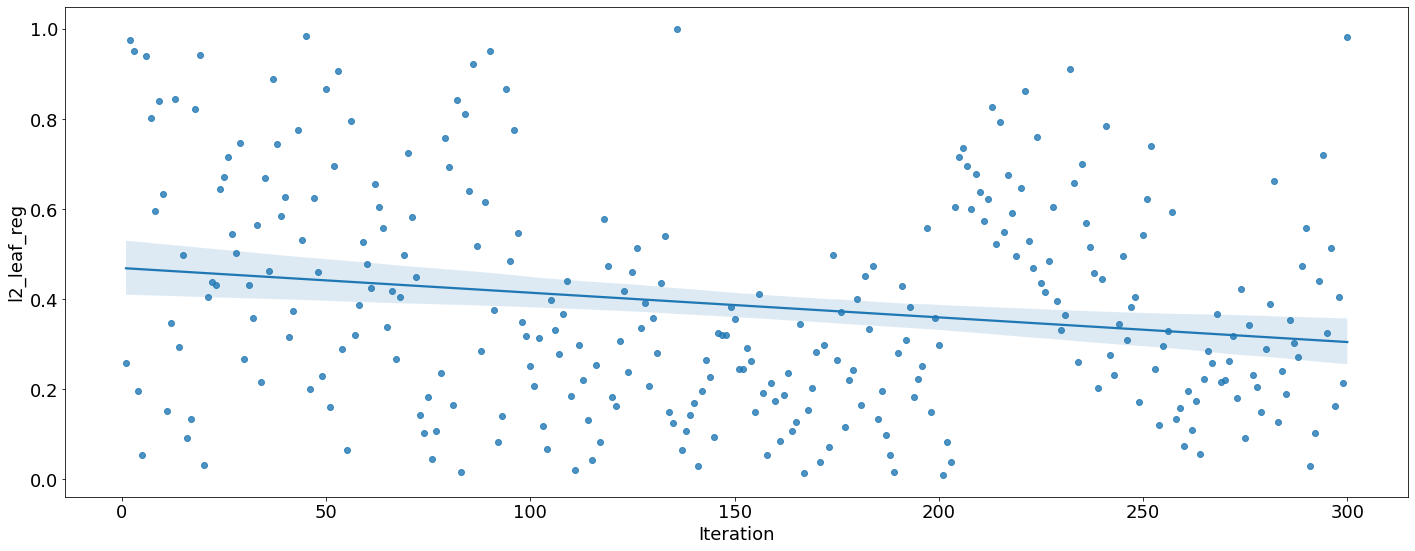

In [ ]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data = bayes_params, label = 'Bayes Optimization') 
ax.set(xlabel = 'Iteration', ylabel = 'l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [13]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Catboost/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Catboost/Model_Explanations


In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_Upsampling_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_test.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/LoanStatus/Catboost/Model_Explanations/best_bayes_Upsampling_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode("UTF-8"))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/LoanStatus/Catboost/Model_Explanations/best_bayes_Upsampling_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [14]:
X_test2 = pd.DataFrame(X_test, columns=X.columns)                                                                    

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['current', 'default'],
    mode='classification')

exp = explainer.explain_instance(
    data_row=X_test2.iloc[1],
    predict_fn=best_bayes_Upsampling_model.predict_proba)

exp.save_to_file('best_bayes_Upsampling_300_GPU_LIME.html')


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Catboost/bestBayes_WeightsExplain/

In [ ]:
# Explain weights
explanation = eli.explain_weights_sklearn(perm_importance,
                            feature_names = X_test.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('Catboost_best_bayes_Upsampling_300_GPU_WeightsExplain.csv',
           index=False, encoding='utf-8-sig')